In [1]:
import os
import sys
import shutil
import json
from pathlib import Path

import numpy as np
import pandas as pd
import polars as pl
import torch

project_root = Path.cwd()
while not(project_root /'pyproject.toml').exists() and project_root != project_root.parent:
    project_root = project_root.parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"Added {project_root} to sys.path")

# Import custom modules using absolute imports (project_root is added to sys.path in an earlier cell).
from longgang_trader.alpha.dl_model_factor import inference_on_test_set, load_config
from longgang_trader.backtesting.backtester import Backtester,ensure_market_data_continuity
from longgang_trader.backtesting.strategy import RollingTopQuantileStrategy,SimpleWeightStrategy,RollingMeanStdBreakoutStrategy


Added d:\Notes\Project\LongGangTrader to sys.path


In [2]:
config_dl = {
            "seq_len": 60,
            "hidden_dim": 128,
            "num_layers": 1,
            "dropout": 0.1,
            "batch_size": 1024,
            "num_workers": 0,
            "device": "cuda:0" if torch.cuda.is_available() else "cpu",
        }
config_strategy = {
    "short_window": 20,
    "long_window": 120,
    "std_multiplier":1.5,
    "min_score": 0.0,
    "date_col":"date",
    "symbol_col":"code",
    "weight_col":"factor_score",
}
config_backtester = {
    "close_col": "close",
    "volume_col": "volume",
    "preclose_col": "preclose",
    "limit_pct": 0.1,
    "initial_capital": 1_000_000_000,
    "transaction_cost": 0.001,
    "rebalance_days": 1,
    "start_date": "2023-09-23"
}

In [3]:
data_root = "../data/"
model_path = data_root + "AttentionGRU1129_20day_MSE_labels_20day_lr_0.003_epoch28_valIC0.0602.pt"
features_path = data_root + "test_features.bin"
labels_path = None  # No labels provided for inference
inference_path = data_root + "inference_results.npy"
if not os.path.exists(inference_path):
    inference_on_test_set(
        model_path=model_path,
        feature_path=features_path,
        label_path=labels_path,
        batch_size=config_dl["batch_size"],
        num_workers=config_dl["num_workers"],
        output_file=inference_path,
        universe=None,
    )


In [4]:
factor_scores = np.load(inference_path)  # shape (di, ii)
with open(os.path.join(data_root, "test_ticker_list.json"), "r") as f:
    test_ticker_list = json.load(f)
with open(os.path.join(data_root, "test_tradedate_list.json"), "r") as f:
    test_tradedate_list = json.load(f)

if factor_scores.shape == (len(test_tradedate_list), len(test_ticker_list)):
    print("Factor scores shape matches the test data dimensions.")
    factor_data = pd.DataFrame(
        factor_scores, index=test_tradedate_list, columns=test_ticker_list)
    factor_data = pl.DataFrame(factor_data.reset_index().melt(
        id_vars="index", var_name="code", value_name="factor_score"))
    factor_data = factor_data.rename({"index": "date"})
else:
    raise ValueError(
        f"Factor scores shape {factor_scores.shape} does not match the test data dimensions "
        f"({len(test_tradedate_list)}, {len(test_ticker_list)})."
    )

factor_data = factor_data.with_columns(
    pl.col("date").cast(pl.Utf8).str.strptime(pl.Datetime, format="%Y%m%d").alias("date"),
    pl.col("factor_score").cast(pl.Float64)
).filter(pl.col("code")!="") # pyright: ignore[reportCallIssue]
#factor_data = factor_data.fill_null(0.0)

Factor scores shape matches the test data dimensions.


In [5]:
market_data_path = data_root + "baostock_data_filled.parquet"
strategy = RollingMeanStdBreakoutStrategy(factor_data=factor_data, config=config_strategy)
backtester = Backtester(strategy=strategy,data_path=market_data_path, config=config_backtester)


生成的交易信号 (Rolling Mean+1.5Std Breakout Strategy):
短期窗口: 20, 长期窗口: 120
总交易日数: 487
平均每日持仓数: 146.48
信号数据预览:
shape: (5, 3)
┌─────────────────────┬───────────┬──────────────┐
│ date                ┆ code      ┆ factor_score │
│ ---                 ┆ ---       ┆ ---          │
│ datetime[μs]        ┆ str       ┆ f64          │
╞═════════════════════╪═══════════╪══════════════╡
│ 2023-11-14 00:00:00 ┆ 000001.SZ ┆ 0.002204     │
│ 2023-11-15 00:00:00 ┆ 000001.SZ ┆ 0.002354     │
│ 2023-11-16 00:00:00 ┆ 000001.SZ ┆ 0.002437     │
│ 2023-11-17 00:00:00 ┆ 000001.SZ ┆ 0.002615     │
│ 2023-11-20 00:00:00 ┆ 000001.SZ ┆ 0.002841     │
└─────────────────────┴───────────┴──────────────┘
Rust 回测成功完成。


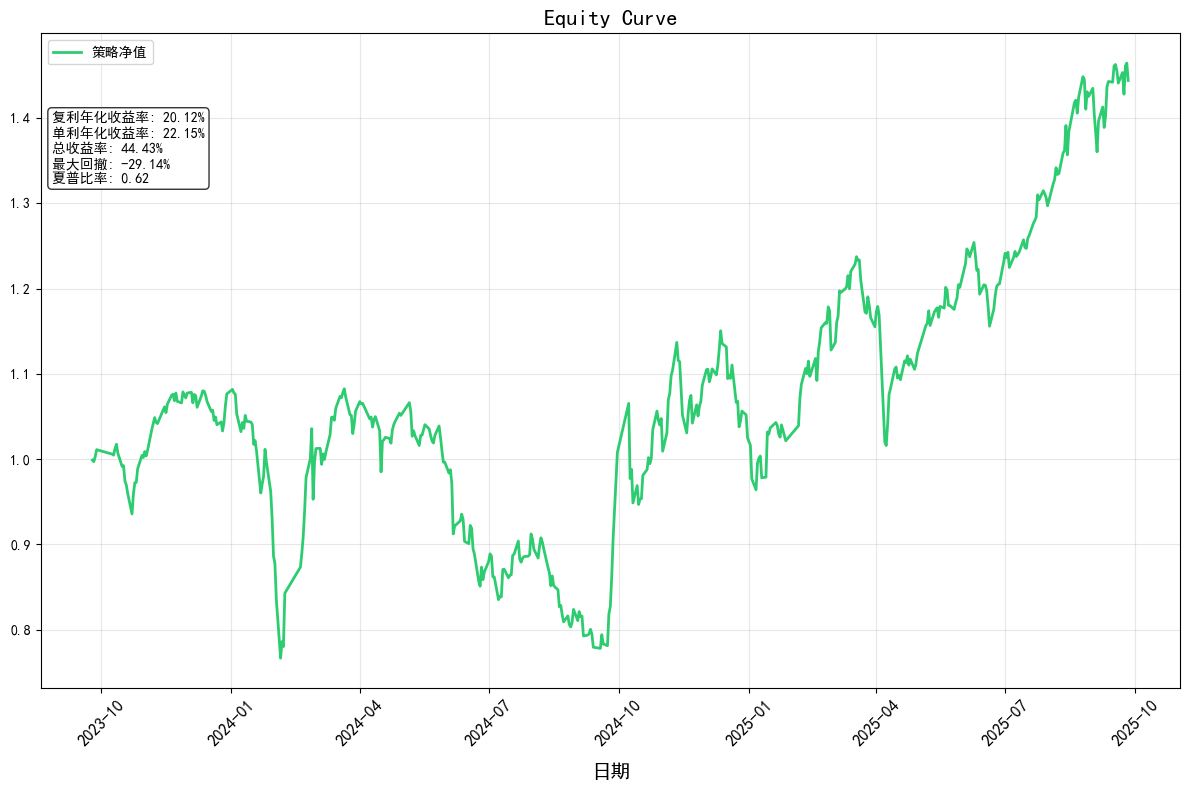

In [6]:
backtester.run_backtest()
backtester.plot_equity_curve()

In [7]:
signals = strategy.generate_signals_for_all_dates()


生成的交易信号 (Rolling Mean+1.5Std Breakout Strategy):
短期窗口: 20, 长期窗口: 120
总交易日数: 487
平均每日持仓数: 146.48
信号数据预览:
shape: (5, 3)
┌─────────────────────┬───────────┬──────────────┐
│ date                ┆ code      ┆ factor_score │
│ ---                 ┆ ---       ┆ ---          │
│ datetime[μs]        ┆ str       ┆ f64          │
╞═════════════════════╪═══════════╪══════════════╡
│ 2023-11-14 00:00:00 ┆ 000001.SZ ┆ 0.002204     │
│ 2023-11-15 00:00:00 ┆ 000001.SZ ┆ 0.002354     │
│ 2023-11-16 00:00:00 ┆ 000001.SZ ┆ 0.002437     │
│ 2023-11-17 00:00:00 ┆ 000001.SZ ┆ 0.002615     │
│ 2023-11-20 00:00:00 ┆ 000001.SZ ┆ 0.002841     │
└─────────────────────┴───────────┴──────────────┘


In [8]:
signals

date,code,factor_score
datetime[μs],str,f64
2023-11-14 00:00:00,"""000001.SZ""",0.002204
2023-11-15 00:00:00,"""000001.SZ""",0.002354
2023-11-16 00:00:00,"""000001.SZ""",0.002437
2023-11-17 00:00:00,"""000001.SZ""",0.002615
2023-11-20 00:00:00,"""000001.SZ""",0.002841
…,…,…
2024-11-25 00:00:00,"""688981.SH""",0.010428
2024-11-26 00:00:00,"""688981.SH""",0.009255
2025-01-24 00:00:00,"""688981.SH""",0.005005
